In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

sys.path.insert(0, "../")

# import warnings
# warnings.filterwarnings('ignore')

from michael import janet

In [2]:
uni = pd.read_csv("/Users/oliver.hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [3]:
index = 4#uni[uni.source_id == int(48977371798954368)].index[0]

In [4]:
len(uni)

792

/Users/oliver.hall/Research/michael/Examples/../michael/janet.py:230: UserWarning: RUNNING ON TARGET 4, 5310986619293965440, eleanor
  warnings.warn(f'RUNNING ON TARGET {index}, {df.loc[index, "source_id"]}, {pipeline}')


Target DR3 ID 5310986619293965440 has tesscut data available on MAST for Sectors 8, 9, 10, 35, 36
Data already downloaded for Sector 8.
Data already downloaded for Sector 9.
Data already downloaded for Sector 10.
Data already downloaded for Sector 35.
Data already downloaded for Sector 36.


/opt/anaconda3/envs/michael10/lib/python3.10/site-packages/eleanor-2.0.5-py3.10.egg/eleanor/source.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sectors == 'all':
/Users/oliver.hall/Research/michael/Examples/../michael/janet.py:138: UserWarning: Your upper period limit is longer than half your longest set of consecutive TESS sectors. You'll be more prone to harmonics.
  warnings.warn(UserWarning("Your upper period limit is longer than half your "+
/opt/anaconda3/envs/michael10/lib/python3.10/site-packages/jazzhands/wavelets.py:488: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Period range automatically set to 0.75x the length of the longest baseline.
For this target, this is 60.75 days.
### Running Simple Astropy Lomb-Scargle on Sector 8-10 on star 5310986619293965440 ###
### Completed Simple Astropy Lomb-Scargle for Sector 8-10 on star 5310986619293965440 ###
### Running Wavelet Estimation for Sector 8-10 on star 5310986619293965440 ###


100%|███████████████████████████████████████| 1150/1150 [00:38<00:00, 30.01it/s]


### Completed Wavelet Estimation for Sector 8-10 on star 5310986619293965440 ###
### Running Composite ACF estimation for Sector 8-10 on star 5310986619293965440 ###
### Completed Composite ACF estimation for Sector 8-10 on star 5310986619293965440 ###
### Running ACF Estimation on star 5310986619293965440 ###
### Completed ACF Estimation for Sector 8-10 on star 5310986619293965440 ###
### Running Simple Astropy Lomb-Scargle on Sector 35-36 on star 5310986619293965440 ###
### Completed Simple Astropy Lomb-Scargle for Sector 35-36 on star 5310986619293965440 ###
### Running Wavelet Estimation for Sector 35-36 on star 5310986619293965440 ###


100%|█████████████████████████████████████████| 747/747 [01:06<00:00, 11.25it/s]
/Users/oliver.hall/Research/michael/Examples/../michael/validate.py:173: UserWarning: One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.
  warnings.warn("One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.")


### Completed Wavelet Estimation for Sector 35-36 on star 5310986619293965440 ###
### Running Composite ACF estimation for Sector 35-36 on star 5310986619293965440 ###
### Completed Composite ACF estimation for Sector 35-36 on star 5310986619293965440 ###
### Running ACF Estimation on star 5310986619293965440 ###
### Completed ACF Estimation for Sector 35-36 on star 5310986619293965440 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


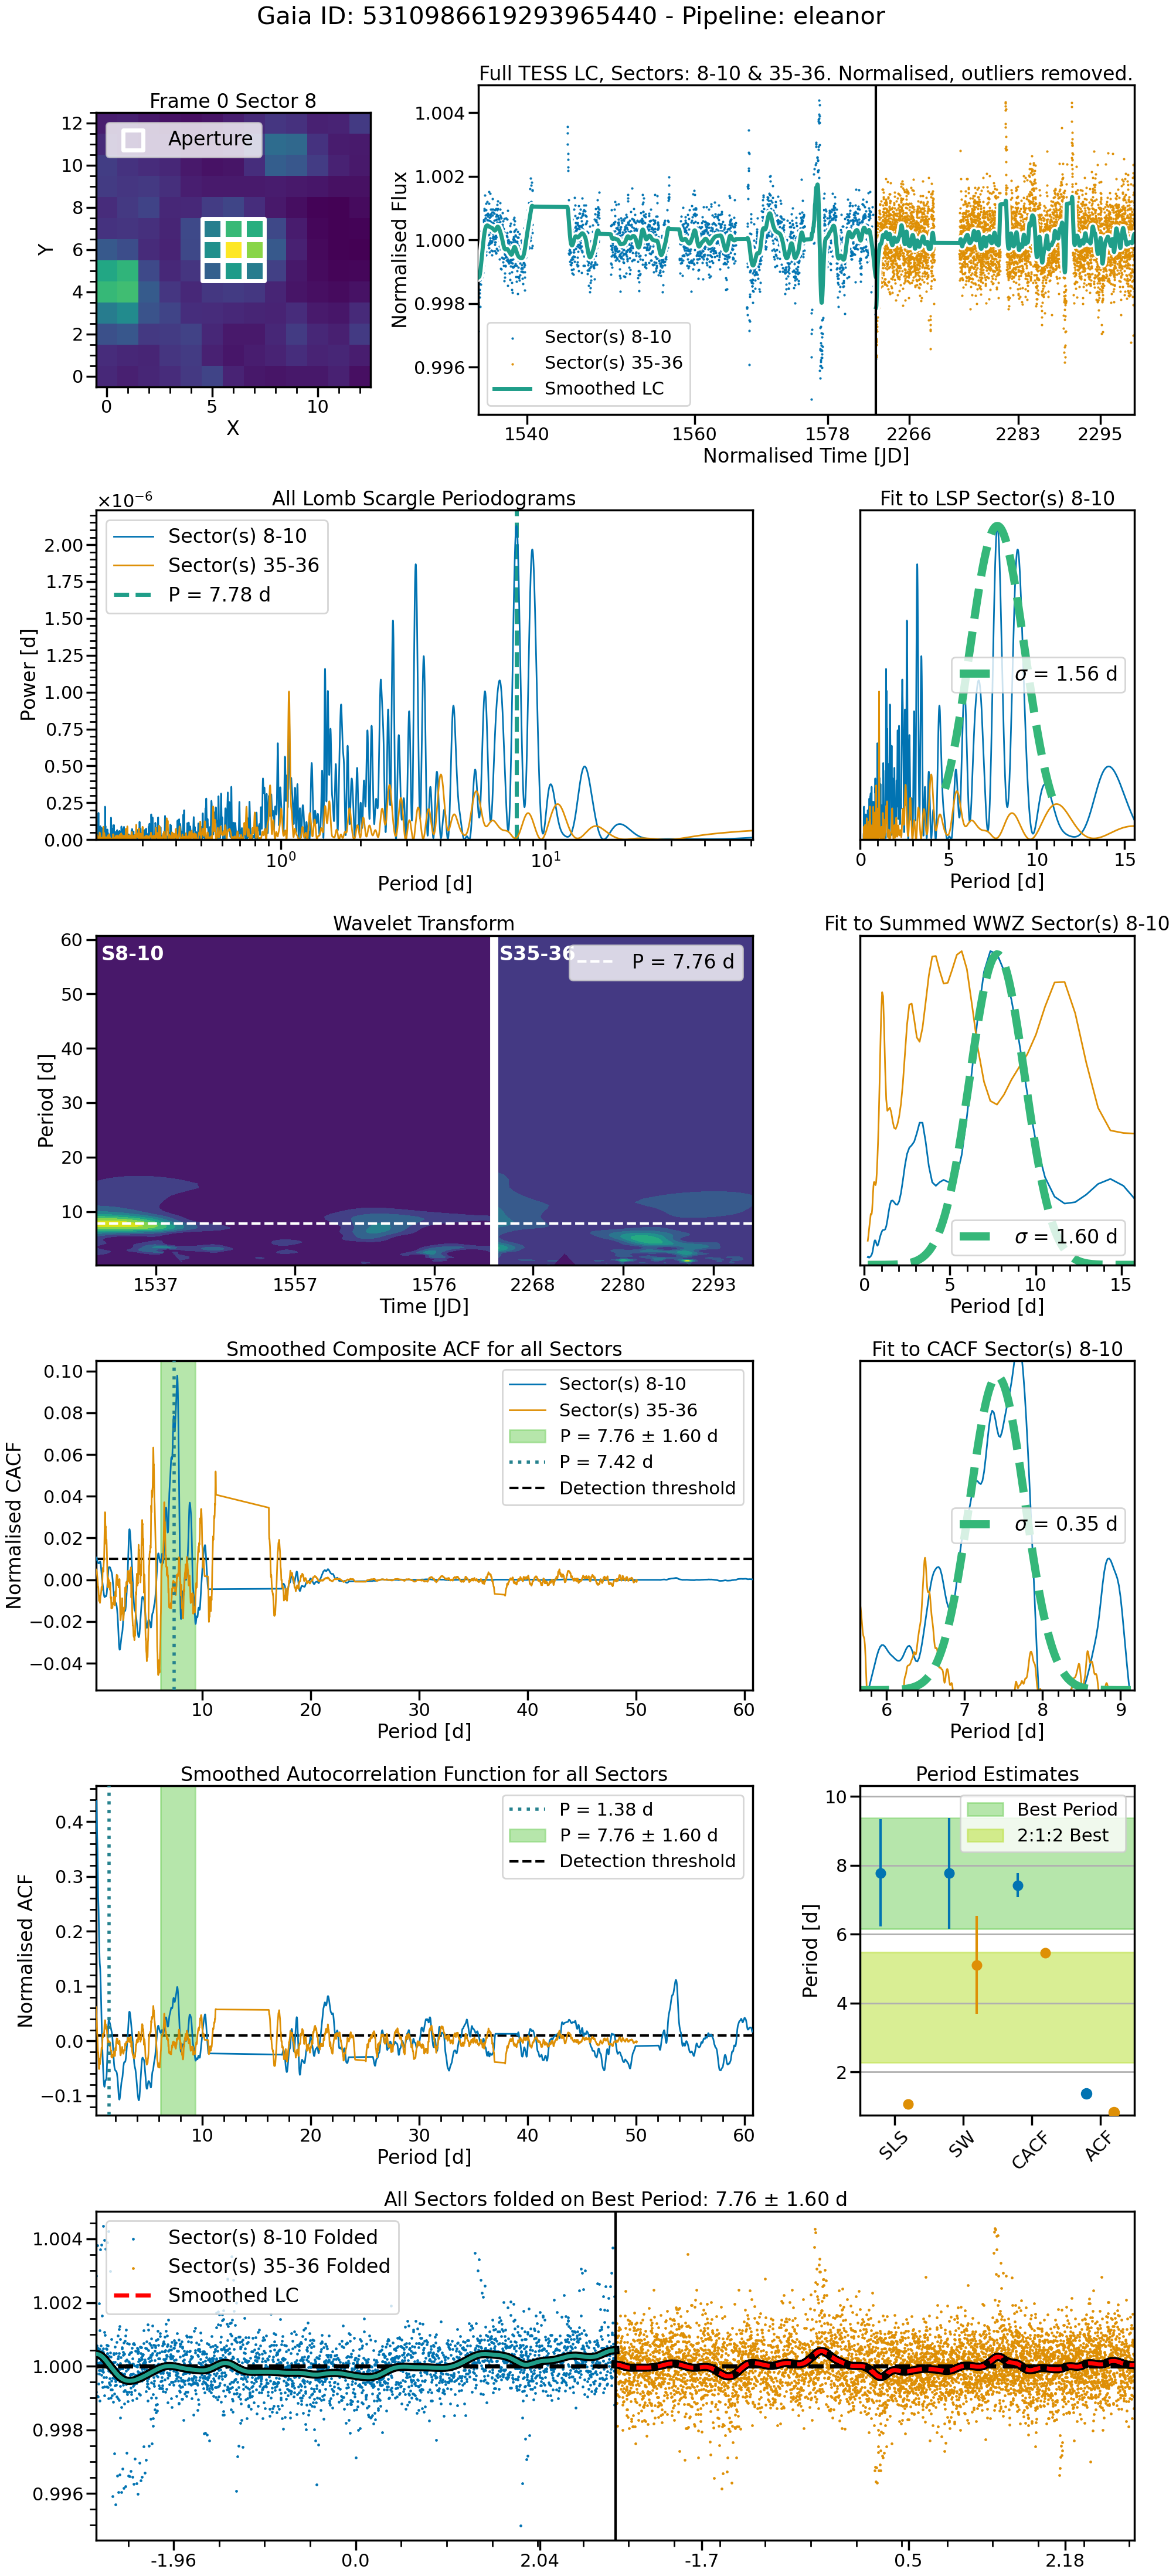

/Users/oliver.hall/Research/michael/Examples/../michael/janet.py:230: UserWarning: RUNNING ON TARGET 4, 5310986619293965440, eleanor-corner
  warnings.warn(f'RUNNING ON TARGET {index}, {df.loc[index, "source_id"]}, {pipeline}')


Target DR3 ID 5310986619293965440 has tesscut data available on MAST for Sectors 8, 9, 10, 35, 36
Data already downloaded for Sector 8.
Data already downloaded for Sector 9.
Data already downloaded for Sector 10.
Data already downloaded for Sector 35.
Data already downloaded for Sector 36.


/opt/anaconda3/envs/michael10/lib/python3.10/site-packages/eleanor-2.0.5-py3.10.egg/eleanor/source.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sectors == 'all':
/Users/oliver.hall/Research/michael/Examples/../michael/janet.py:138: UserWarning: Your upper period limit is longer than half your longest set of consecutive TESS sectors. You'll be more prone to harmonics.
  warnings.warn(UserWarning("Your upper period limit is longer than half your "+


Period range automatically set to 0.75x the length of the longest baseline.
For this target, this is 60.75 days.
### Running Simple Astropy Lomb-Scargle on Sector 8-10 on star 5310986619293965440 ###
### Completed Simple Astropy Lomb-Scargle for Sector 8-10 on star 5310986619293965440 ###
### Running Wavelet Estimation for Sector 8-10 on star 5310986619293965440 ###


100%|███████████████████████████████████████| 1158/1158 [00:39<00:00, 29.48it/s]


### Completed Wavelet Estimation for Sector 8-10 on star 5310986619293965440 ###
### Running Composite ACF estimation for Sector 8-10 on star 5310986619293965440 ###
### Completed Composite ACF estimation for Sector 8-10 on star 5310986619293965440 ###
### Running ACF Estimation on star 5310986619293965440 ###
### Completed ACF Estimation for Sector 8-10 on star 5310986619293965440 ###
### Running Simple Astropy Lomb-Scargle on Sector 35-36 on star 5310986619293965440 ###
### Completed Simple Astropy Lomb-Scargle for Sector 35-36 on star 5310986619293965440 ###
### Running Wavelet Estimation for Sector 35-36 on star 5310986619293965440 ###


100%|█████████████████████████████████████████| 747/747 [01:23<00:00,  8.94it/s]
/Users/oliver.hall/Research/michael/Examples/../michael/validate.py:173: UserWarning: One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.
  warnings.warn("One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.")


### Completed Wavelet Estimation for Sector 35-36 on star 5310986619293965440 ###
### Running Composite ACF estimation for Sector 35-36 on star 5310986619293965440 ###
### Completed Composite ACF estimation for Sector 35-36 on star 5310986619293965440 ###
### Running ACF Estimation on star 5310986619293965440 ###
### Completed ACF Estimation for Sector 35-36 on star 5310986619293965440 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [ ]:
for method in ['eleanor', 'eleanor-corner','eleanor-pca', 'unpopular','tess-sip', 'tess-sip-detrended']:
    j = janet.boot(uni, index=index, pipeline = method)
    j.prepare_data()
    j.get_rotation(period_range = 'auto')
    j.validate_rotation()
    j.view()
    plt.show()

In [ ]:
j.void['pg_8-10'][np.isfinite(j.void['pg_8-10'].power)].plot()

In [ ]:
list(j.void)

In [ ]:
wwz = j.void['35-36_wwz']
wt = j.void['35-36_wt']

# Create data to fit
w = np.sum(wwz, axis=1)
w /= w.max() #Normalize
p = 1/wt.nus

max_w = np.max(w)
max_p = p[np.argmax(w)]

s = (p > 0.6*max_p) & (p < 1.4*max_p)
w = w[s]
p = p[s]

In [ ]:
w